In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from scipy.stats import qmc
from scipy.stats import norm, ttest_ind
import os

In [2]:
# Set up directories for saving output
SAVE_DIR = 'media/'
os.makedirs(SAVE_DIR, exist_ok=True)
# Define the limits of the complex plane for the Mandelbrot calculations
X_LIM = (-2, 0.75)
Y_LIM = (-1.25, 1.25)

In [3]:
@jit(nopython=True)
def mandelbrot(z, max_iter):
    """
    Determine if a complex point is in the Mandelbrot set.
    :param z: Complex point.
    :param max_iter: Maximum number of iterations to determine set membership.
    :return: Iteration count when z escapes the set or max_iter if it doesn't.
    """
    c = z
    for i in range(max_iter):
        if np.abs(z) > 2:
            return i
        z = z*z + c
    return max_iter

# Function to calculate the bootstrap confidence interval for a given dataset.
def bootstrap_confidence_interval(data, num_bootstrap_iters=1000, confidence_level=0.95):
    """
    Compute the bootstrap confidence interval for a dataset.
    :param data: Dataset to analyze.
    :param num_bootstrap_iters: Number of bootstrap iterations.
    :param confidence_level: Confidence level for the interval.
    :return: Calculated percentile interval.
    """
    bootstrap_means = np.empty(num_bootstrap_iters)
    for i in range(num_bootstrap_iters):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return np.percentile(bootstrap_means, [(1 - confidence_level) / 2 * 100, (1 + confidence_level) / 2 * 100])

# Function for hypothesis testing between two datasets.
def hypothesis_testing(data1, data2, alpha=0.05):
    """
    Perform hypothesis testing to compare two datasets.
    :param data1: First dataset.
    :param data2: Second dataset.
    :param alpha: Significance level.
    :return: Test statistic and p-value.
    """
    stat, p_value = stats.ttest_ind(data1, data2)
    if p_value < alpha:
        print("Reject the null hypothesis, indicating a significant difference between the two samples.")
    else:
        print("Fail to reject the null hypothesis, indicating no significant difference between the two samples.")
    return stat, p_value

# Function to compute and analyze statistics of the generated Mandelbrot set.
def mandelbrot_statistics(c_points, counts, method, previous_stats=None, tolerance=0.01):
    """
    Calculate and analyze the statistics of Mandelbrot set points.
    :param c_points: Complex points.
    :param counts: Iteration counts for each point.
    :param method: Method used for generating the points.
    :param previous_stats: Previous statistical data for comparison.
    :param tolerance: Tolerance level for determining significant changes.
    :return: A dictionary of statistical results.
    """
    total_area = abs(X_LIM[0] - X_LIM[1]) * abs(Y_LIM[0] - Y_LIM[1])
    max_iter = np.max(counts)
    mandelbrot_ratio = np.count_nonzero(counts == max_iter) / counts.size
    mandelbrot_area = total_area * mandelbrot_ratio
    inside = counts == max_iter
    area_samples = inside / (counts.size / total_area)
    sample_mean = np.mean(area_samples)
    sample_std = np.std(area_samples, ddof=1)  # ddof=1 for sample std. dev.
    confidence_interval = norm.interval(0.95, loc=sample_mean, scale=sample_std / np.sqrt(area_samples.size))

    has_converged = False
    if previous_stats:
        mean_change = abs(previous_stats['mean'] - sample_mean)
        std_change = abs(previous_stats['std'] - sample_std)
        if mean_change < tolerance and std_change < tolerance:
            has_converged = True
    
    stats = {
        'area': mandelbrot_area,
        'mean': sample_mean,
        'std': sample_std,
        'conf_int': confidence_interval,
        'has_converged': has_converged
    }
    
    # Print only if there's a significant change or upon convergence
    if not previous_stats or mean_change >= tolerance or std_change >= tolerance or has_converged:
        print(f"Mandelbrot area: {mandelbrot_area} using {method} method")
        print(f"Mean estimated area: {sample_mean}")
        print(f"Standard deviation of estimated area: {sample_std}")
        print(f"95% Confidence interval for the estimated area: {confidence_interval}")
        if has_converged:
            print("Stopping criterion met - simulation has converged.")
    
    return stats

# Utility for visualizing the Mandelbrot set. Supports different methods including fixed grid and Monte Carlo.
def plot_mandelbrot(c_points, counts, method, max_iter=250, save=True, show=True):
    # Utility for visualizing the Mandelbrot set. Supports different methods including fixed grid and Monte Carlo.
    N = int(np.sqrt(len(counts)))
    if method == 'fixed':
        # For a fixed grid, reshape counts to a 2D array and display
        image_data = counts.reshape(N, N)
        plt.imshow(image_data, cmap='hot', extent=[*X_LIM, *Y_LIM])
    elif method == 'monte-carlo':
        # For Monte Carlo, use histogram2d for plotting
        image_data, _, _ = np.histogram2d(x=c_points.imag, y=c_points.real, bins=N, weights=counts)
        plt.imshow(image_data, cmap='hot', extent=[*Y_LIM, *X_LIM])
    else:
        raise ValueError('Invalid argument, method does not exist.')
    
    plt.colorbar(shrink=0.85, label='# iterations')
    plt.axis('off')
    if save:
        plt.savefig(f'{SAVE_DIR}mandelbrot_{method}_{max_iter}_{N}.png', dpi=300)
    if show:
        plt.show()

# Enhanced plotting utility to display the Mandelbrot set with gradient colors.
def plot_mandelbrot_gradient(c_points, counts, method, max_iter=250, save=True, show=True):
    N = int(np.sqrt(len(counts)))  # Determine the plot size for the gradient representation
    
    # Initialize an image array for RGB color representation
    image_data = np.zeros((N, N, 3), dtype=np.uint8)

    plt.figure(figsize=(8, 8))  # Create a figure for the plot

    if method == 'fixed':
        counts_reshaped = counts.reshape((N, N))
        norm_counts = counts_reshaped / max_iter  # Normalize iteration counts
        # Convert normalized counts to RGB color space and display
        image_data = (plt.cm.jet(norm_counts)[:,:,:3] * 255).astype(np.uint8)
        plt.imshow(image_data, extent=[*X_LIM, *Y_LIM])
    
    elif method in ['monte-carlo', 'lhs', 'orthogonal', 'random']:
        # For sampling methods, create a 2D histogram and convert it to RGB
        hist, x_edges, y_edges = np.histogram2d(c_points.real, c_points.imag, bins=N, range=[X_LIM, Y_LIM], weights=counts)
        norm_hist = hist / hist.max()  # Normalize iteration counts for the histogram
        image_data = (plt.cm.jet(norm_hist)[:,:,:3] * 255).astype(np.uint8)
        plt.imshow(image_data, extent=[*X_LIM, *Y_LIM])

    else:
        raise ValueError(f"Invalid method: {method}")

    plt.colorbar(label='# iterations')
    plt.axis('off')

    if save:
        # Save the gradient plot if requested
        filename = f'{SAVE_DIR}mandelbrot_{method}_gradient_{max_iter}_{N}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
        print(f"Saved: {filename}")

    if show:
        plt.show()

# Function for generating the Mandelbrot set on a fixed grid.
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_fixed(max_iter=250, size=1_000):
    # Prepare real and imaginary parts for the fixed grid
    real_parts = np.linspace(*X_LIM, size)
    imag_parts = np.linspace(*Y_LIM, size)
    # Initialize arrays for complex points and iteration counts
    c_points = np.zeros((size, size), dtype=np.complex128)
    counts = np.zeros((size, size), dtype=np.int32)
    # Calculate Mandelbrot set for each point in the grid
    for i in prange(size):
        for j in prange(size):
            z = complex(real_parts[j], imag_parts[i])
            c_points[i, j] = z
            counts[i, j] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

# Function for generating the Mandelbrot set using Monte Carlo method with randomly sampled points.
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_mc(max_iter=250, n_points=1_000_000):
    # Randomly sample real and imaginary parts within the specified limits
    real_parts = np.random.uniform(low=X_LIM[0], high=X_LIM[1], size=n_points)
    imag_parts = np.random.uniform(low=Y_LIM[0], high=Y_LIM[1], size=n_points)
    # Combine real and imaginary parts to form complex points
    c_points = np.stack((real_parts, imag_parts), axis=-1).view(np.complex128)
    counts = np.zeros((n_points), dtype=np.int32)
    # Perform Mandelbrot set computation for each sampled point
    for i in prange(n_points):
        z = c_points[i]
        counts[i] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

Mandelbrot area: 1.518556875 using monte-carlo method
Mean estimated area: 1.518556875e-06
Standard deviation of estimated area: 2.8520293944991003e-06
95% Confidence interval for the estimated area: (1.512967000103932e-06, 1.5241467498960677e-06)
Saved: media/mandelbrot_monte-carlo_gradient_250_1000.png


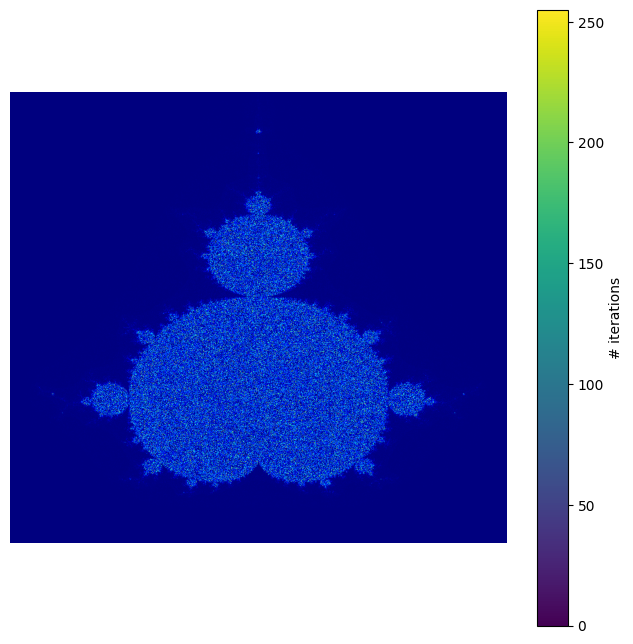

In [4]:
points_mc, counts_mc = mandelbrot_parallel_mc()
mandelbrot_statistics(points_mc, counts_mc, method='monte-carlo')
plot_mandelbrot_gradient(points_mc, counts_mc, method='monte-carlo')

Mandelbrot area: 1.51859125 using fixed method
Mean estimated area: 1.51859125e-06
Standard deviation of estimated area: 2.852052522899437e-06
95% Confidence interval for the estimated area: (1.5130013297731005e-06, 1.5241811702268994e-06)
Saved: media/mandelbrot_fixed_gradient_250_1000.png


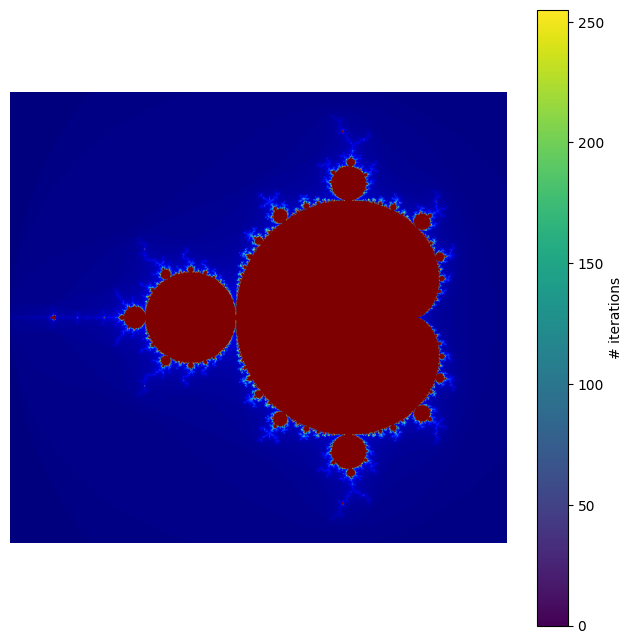

In [5]:
points_fixed, counts_fixed = mandelbrot_parallel_fixed()
mandelbrot_statistics(points_fixed, counts_fixed, method='fixed')
plot_mandelbrot_gradient(points_fixed, counts_fixed, method='fixed')

In [11]:
def latin_hypercube_sampling(max_iter, n_samples):
    """
    Perform Latin Hypercube Sampling to estimate the area of the Mandelbrot set.
    
    Latin Hypercube Sampling improves sample diversity by ensuring that each sample
    is the only one in each axis-aligned hyperplane. It is particularly useful in 
    multi-dimensional Monte Carlo simulations where it reduces the variability of the results.
    
    :param max_iter: Maximum iterations to determine Mandelbrot set membership.
    :param n_samples: Number of samples to draw.
    :return: A tuple of sampled complex points and their Mandelbrot iteration counts.
    """
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n_samples)
    range_real = X_LIM[1] - X_LIM[0]
    range_imag = Y_LIM[1] - Y_LIM[0]
    points = np.zeros((n_samples, 2))
    points[:, 0] = X_LIM[0] + sample[:, 0] * range_real
    points[:, 1] = Y_LIM[0] + sample[:, 1] * range_imag
    c_points = points[:, 0] + 1j * points[:, 1]
    counts = np.array([mandelbrot(c, max_iter) for c in c_points])
    return c_points, counts


In [12]:
@jit(nopython=True)
def stratified_sampling(max_iter, n_strata, samples_per_stratum):
    """
    Utilize stratified sampling to estimate the Mandelbrot set area.
    
    Stratified sampling ensures that the samples are evenly distributed across the 
    domain of interest, which can lead to more accurate and reliable estimates of the Mandelbrot set area.
    
    :param max_iter: Maximum iterations for Mandelbrot calculations.
    :param n_strata: Number of strata to divide the sample space.
    :param samples_per_stratum: Number of samples per stratum.
    :return: A tuple of sampled complex points and their Mandelbrot iteration counts.
    """
    real_strata_edges = np.linspace(*X_LIM, n_strata + 1)
    imag_strata_edges = np.linspace(*Y_LIM, n_strata + 1)
    
    c_points = np.zeros(n_strata * n_strata * samples_per_stratum, dtype=np.complex128)
    counts = np.zeros(n_strata * n_strata * samples_per_stratum, dtype=np.int32)
    
    index = 0
    for i in prange(n_strata):
        for j in prange(n_strata):
            real_samples = np.random.uniform(real_strata_edges[i], real_strata_edges[i+1], samples_per_stratum)
            imag_samples = np.random.uniform(imag_strata_edges[j], imag_strata_edges[j+1], samples_per_stratum)
            
            for k in prange(samples_per_stratum):
                c = real_samples[k] + 1j * imag_samples[k]
                c_points[index] = c
                counts[index] = mandelbrot(c, max_iter)
                index += 1

    return c_points, counts

In [20]:
import pandas as pd

def investigate_convergence(iter_range, sample_sizes, improvement_method=None):
    """
    Explore the convergence behavior of the Mandelbrot set area estimation as a function of
    iterations and sample size, and assess the efficacy of different sampling methods.

    :param iter_range: A range of iteration counts to test.
    :param sample_sizes: A range of sample sizes to test.
    :param improvement_method: The sampling method used to improve convergence.
    :return: A DataFrame with the area estimates and associated statistics.
    """
    results_list = []

    # Iterate over all combinations of iteration counts and sample sizes.
    for max_iter in iter_range:
        for n_samples in sample_sizes:
            # Ensure a balance between iterations and sample size to compare their errors.
            if n_samples >= max_iter:  
                # Apply the appropriate sampling method.
                if improvement_method == 'lhs':
                    c_points, counts = latin_hypercube_sampling(max_iter, n_samples)
                elif improvement_method == 'stratified':
                    n_strata = int(np.sqrt(n_samples))
                    samples_per_stratum = n_samples // n_strata
                    c_points, counts = stratified_sampling(max_iter, n_strata, samples_per_stratum)
                else:
                    c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)

                # Calculate statistics for the current configuration.
                stats = mandelbrot_statistics(c_points, counts, method=improvement_method or 'monte-carlo')
                results_list.append({
                    'iterations': max_iter,
                    'samples': n_samples,
                    'estimated_area': stats['area'],
                    'std_dev': stats['std'],
                    'conf_int_low': stats['conf_int'][0],
                    'conf_int_high': stats['conf_int'][1]
                })

    # Compile the results into a DataFrame for further analysis.
    results_df = pd.DataFrame(results_list)

    # Analyze and visualize the convergence behavior.
    visualize_convergence_analysis(results_df, iter_range, sample_sizes)

    return results_df

def visualize_convergence_analysis(results_df, iter_range, sample_sizes):
    """
    Generate plots to visualize the error in estimated area as a function of iteration count
    and sample size, based on reference areas from the convergence study.

    :param results_df: DataFrame containing the results of the convergence study.
    :param iter_range: Range of iteration counts used in the study.
    :param sample_sizes: Range of sample sizes used in the study.
    """
    largest_i = max(iter_range)
    reference_area_by_iter = results_df[results_df['samples'] == max(sample_sizes)].set_index('iterations')['estimated_area']
    reference_area_by_samples = results_df[results_df['iterations'] == max(iter_range)].set_index('samples')['estimated_area']

    plot_error_by_iteration(results_df, iter_range, sample_sizes, reference_area_by_iter)
    plot_error_by_sample_size(results_df, iter_range, sample_sizes, reference_area_by_samples)

# Split plotting into dedicated functions for clarity and maintainability.
def plot_error_by_iteration(results_df, iter_range, sample_sizes, reference_area_by_iter):
    """
    Plot the error in estimated area as a function of iteration count.
    """
    plt.figure(figsize=(10, 5))
    for sample_size in sample_sizes:
        errors = calculate_errors_by_iteration(results_df, iter_range, sample_size, reference_area_by_iter)
        plt.plot(iter_range, errors, '-o', label=f'Samples={sample_size}')
    plt.xlabel('Iteration Count')
    plt.ylabel('Error from reference area by iteration')
    plt.legend()
    plt.title('Error Analysis for Varying Iteration Counts')
    plt.grid(True)
    plt.show()

def plot_error_by_sample_size(results_df, iter_range, sample_sizes, reference_area_by_samples):
    """
    Plot the error in estimated area as a function of sample size.
    """
    plt.figure(figsize=(10, 5))
    for iter_count in iter_range:
        errors = calculate_errors_by_sample_size(results_df, iter_count, sample_sizes, reference_area_by_samples)
        plt.plot(sample_sizes, errors, '-o', label=f'Iterations={iter_count}')
    plt.xlabel('Sample Size')
    plt.ylabel('Error from reference area by sample size')
    plt.legend()
    plt.title('Error Analysis for Varying Sample Sizes')
    plt.grid(True)
    plt.show()

def calculate_errors_by_iteration(results_df, iter_range, sample_size, reference_area_by_iter):
    """
    Calculate errors in estimated area for a fixed sample size across different iteration counts.
    """
    errors = []
    for iter_count in iter_range:
        if not results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)].empty:
            estimated_area = results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)]['estimated_area'].iloc[0]
            ref_area = reference_area_by_iter[iter_count]
            errors.append(abs(estimated_area - ref_area))
    return errors

def calculate_errors_by_sample_size(results_df, iter_count, sample_sizes, reference_area_by_samples):
    """
    Calculate errors in estimated area for a fixed iteration count across different sample sizes.
    """
    errors = []
    for sample_size in sample_sizes:
        if not results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)].empty:
            estimated_area = results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)]['estimated_area'].iloc[0]
            ref_area = reference_area_by_samples[sample_size]
            errors.append(abs(estimated_area - ref_area))
    return errors

Mandelbrot area: 1.536975 using monte-carlo method
Mean estimated area: 1.5369750000000003e-05
Standard deviation of estimated area: 2.864348620420565e-05
95% Confidence interval for the estimated area: (1.5192219095427494e-05, 1.5547280904572513e-05)
Mandelbrot area: 1.5425923201412388 using monte-carlo method
Mean estimated area: 1.0315997165468982e-05
Standard deviation of estimated area: 1.9180006785348395e-05
95% Confidence interval for the estimated area: (1.021878359994854e-05, 1.0413210730989423e-05)
Mandelbrot area: 1.551383907408567 using monte-carlo method
Mean estimated area: 6.9380245047474865e-06
Standard deviation of estimated area: 1.2852290225151207e-05
95% Confidence interval for the estimated area: (6.884753990571049e-06, 6.991295018923924e-06)
Mandelbrot area: 1.5421408170589466 using monte-carlo method
Mean estimated area: 4.612078885841872e-06
Standard deviation of estimated area: 8.5766051864424e-06
95% Confidence interval for the estimated area: (4.5830085628749

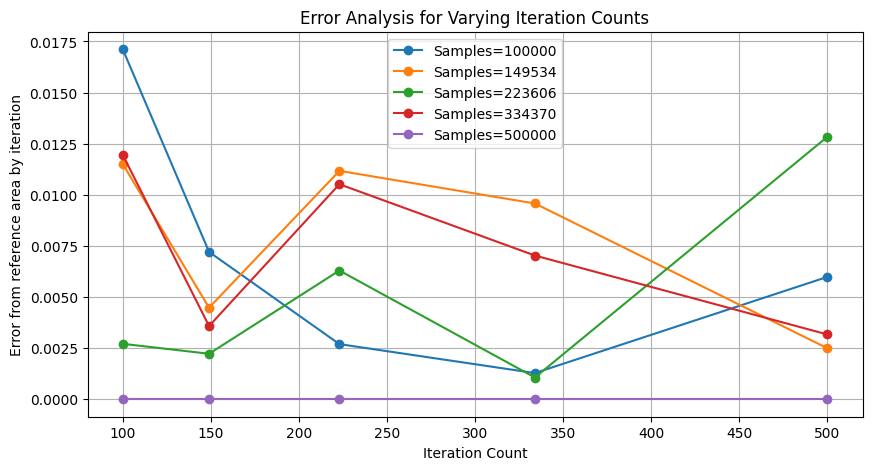

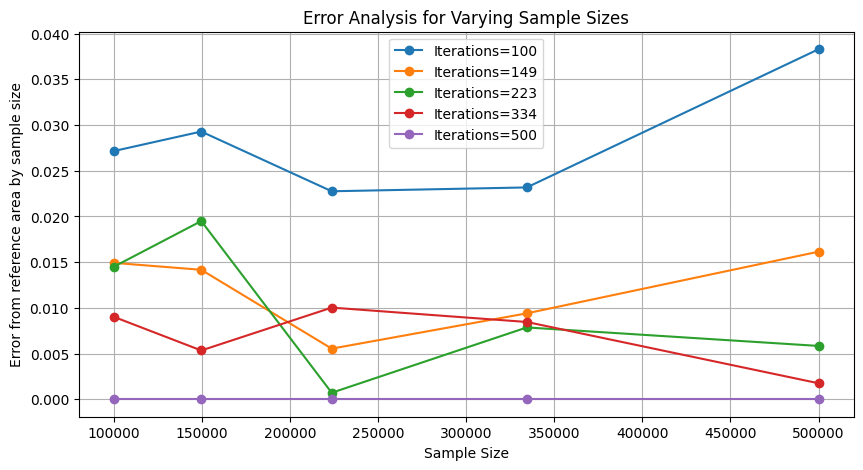

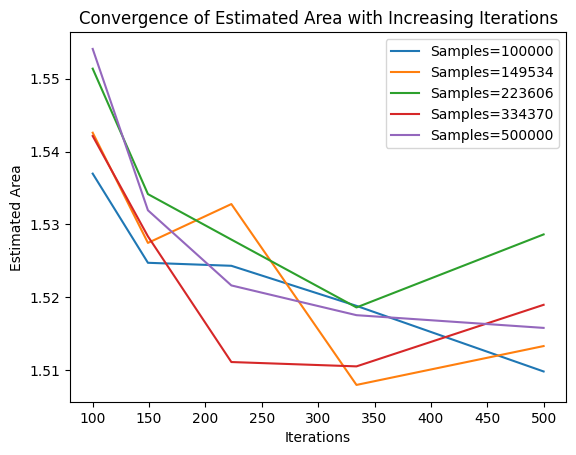

In [15]:
iter_range = np.geomspace(100, 500, num=5).astype(int)  # Iteration range
sample_sizes = np.geomspace(100000, 500000, num=5).astype(int)  # Sample size range
results_df = investigate_convergence(iter_range, sample_sizes)
# Visualizes the convergence of estimated Mandelbrot set area with increasing iterations.
for samples in sample_sizes:
    subset = results_df[results_df['samples'] == samples]
    plt.plot(subset['iterations'], subset['estimated_area'], label=f'Samples={samples}')

plt.xlabel('Iterations')
plt.ylabel('Estimated Area')
plt.legend()
plt.title('Convergence of Estimated Area with Increasing Iterations')
plt.show()

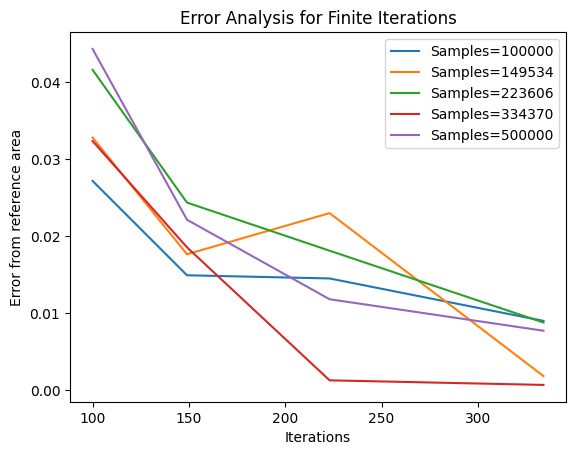

In [16]:
# Analyzes the error from the reference area for a range of iteration counts.
largest_i = max(iter_range)
reference_area = results_df[results_df['iterations'] == largest_i]['estimated_area'].iloc[0]

# Visualizes the error as a function of iteration count compared to the largest iteration count.
for samples in sample_sizes:
    errors = []
    for i in iter_range:
        if i < largest_i:
            current_area = results_df[(results_df['iterations'] == i) & (results_df['samples'] == samples)]['estimated_area'].iloc[0]
            error = abs(current_area - reference_area)
            errors.append(error)
    plt.plot(iter_range[:-1], errors, label=f'Samples={samples}')

plt.xlabel('Iterations')
plt.ylabel('Error from reference area')
plt.legend()
plt.title('Error Analysis for Finite Iterations')
plt.show()

In [ ]:
# Initiates a convergence investigation using stratified sampling.
results_df = investigate_convergence(iter_range, sample_sizes, improvement_method='stratified') 
#def investigate_convergence(iter_range: {__iter__},
                            # sample_sizes: {__iter__},
                            # improvement_method: Any = None) -> DataFrame

Mandelbrot area: 1.5464066515275667 using stratified method
Mean estimated area: 4.900749013793708e-08
Standard deviation of estimated area: 9.097182405029225e-08
95% Confidence interval for the estimated area: (4.897574886278571e-08, 4.903923141308845e-08)
Mandelbrot area: 1.54646559845562 using stratified method
Mean estimated area: 2.681974776590103e-08
Standard deviation of estimated area: 4.9783846409177425e-08
95% Confidence interval for the estimated area: (2.6806898043308745e-08, 2.6832597488493317e-08)
Mandelbrot area: 1.5465274425786497 using stratified method
Mean estimated area: 1.4676161858601684e-08
Standard deviation of estimated area: 2.7241752704582484e-08
95% Confidence interval for the estimated area: (1.4670960574596152e-08, 1.4681363142607216e-08)
Mandelbrot area: 1.5464946437594855 using stratified method
Mean estimated area: 8.008753096466422e-09
Standard deviation of estimated area: 1.4865975039949842e-08
95% Confidence interval for the estimated area: (8.006656

Mandelbrot area: 1.5494187499999998 using random method
Mean estimated area: 1.54941875e-05
Standard deviation of estimated area: 2.8725664413165514e-05
95% Confidence interval for the estimated area: (1.531614725897072e-05, 1.567222774102928e-05)
Mandelbrot area: 1.545994556421951 using random method
Mean estimated area: 1.033874942435801e-05
Standard deviation of estimated area: 1.9195019761064308e-05
95% Confidence interval for the estimated area: (1.024145976580409e-05, 1.043603908291193e-05)
Mandelbrot area: 1.5578098306843287 using random method
Mean estimated area: 6.96676220979906e-06
Standard deviation of estimated area: 1.2871105053238023e-05
95% Confidence interval for the estimated area: (6.913413711423016e-06, 7.020110708175104e-06)
Mandelbrot area: 1.5451427311062595 using random method
Mean estimated area: 4.621056706960134e-06
Standard deviation of estimated area: 8.582532077621981e-06
95% Confidence interval for the estimated area: (4.591966294851012e-06, 4.65014711906

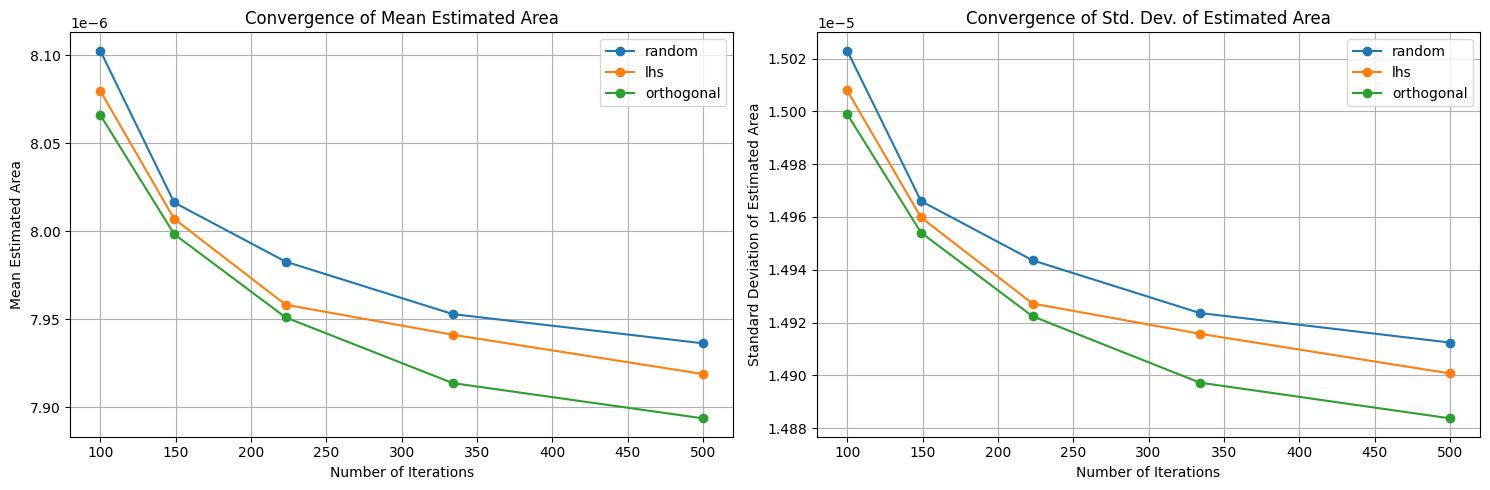

In [18]:
from pyDOE import lhs


def orthogonal_sampling(max_iter, n_samples, d=2):
    """
    Generate orthogonal samples within the Mandelbrot set limits.
    Orthogonal sampling is based on Latin Hypercube Sampling (LHS) but imposes a more regular distribution.
    :param max_iter: The maximum number of iterations per sample for the Mandelbrot calculation.
    :param n_samples: Total number of complex points to sample.
    :param d: Dimension of the sampling grid, default is 2D.
    :return: A tuple of complex points and their respective Mandelbrot set iteration counts.
    """
    intervals = np.linspace(0, 1, int(np.sqrt(n_samples)) + 1)
    points = np.array(np.meshgrid(*([intervals]*d))).T.reshape(-1, d)
    np.random.shuffle(points)
    points = points[:n_samples]
    
    range_real = X_LIM[1] - X_LIM[0]
    range_imag = Y_LIM[1] - Y_LIM[0]
    sampled_points = np.zeros((n_samples, 2))
    sampled_points[:, 0] = X_LIM[0] + points[:, 0] * range_real
    sampled_points[:, 1] = Y_LIM[0] + points[:, 1] * range_imag
    c_points = sampled_points[:, 0] + 1j * sampled_points[:, 1]
    counts = np.array([mandelbrot(c, max_iter) for c in c_points])
    return c_points, counts

def antithetic_variates(c_points, counts, max_iter):
    """
    Use antithetic variates to potentially reduce variance in the Monte Carlo simulation.
    This function takes the negation of complex points as antithetic variates.
    :param c_points: Array of complex points sampled.
    :param counts: Array of iteration counts for the Mandelbrot calculation.
    :param max_iter: Maximum iterations to check for Mandelbrot set membership.
    :return: Averaged counts combining original and antithetic variates.
    """
    antithetic_points = -c_points
    antithetic_counts = np.array([mandelbrot(c, max_iter) for c in antithetic_points])
    return (counts + antithetic_counts) / 2  # Take the average of normal and antithetic counts

def run_simulation(max_iter, n_samples, sampling_method):
    """
    Run multiple simulations of Mandelbrot set calculations using a specified sampling method.
    :param max_iter: The maximum number of iterations for the Mandelbrot set calculation.
    :param n_samples: The number of samples to generate.
    :param sampling_method: The method used for sampling points ('random', 'lhs', 'orthogonal').
    :return: A list of statistical summaries from each simulation run.
    """
    stats_list = []
    for _ in range(10):  # try run 10 simulations and collect statistics
        if sampling_method == 'random':
            c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)
            counts = antithetic_variates(c_points, counts, max_iter)  # Use antithetic variates
        elif sampling_method == 'lhs':
            c_points, counts = latin_hypercube_sampling(max_iter, n_samples)
        elif sampling_method == 'orthogonal':
            c_points, counts = orthogonal_sampling(max_iter, n_samples)
        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")
        stats_list.append(mandelbrot_statistics(c_points, counts, sampling_method))
    return stats_list

def control_variates(counts, known_mean):
    """
    Apply control variates technique to adjust the estimation of the Mandelbrot set area.
    This technique uses known properties of the Mandelbrot set to reduce variance.
    :param counts: The array of raw counts from the Monte Carlo simulation.
    :param known_mean: The known or estimated mean to be used as the control variate.
    :return: Adjusted counts after applying the control variates technique.
    """
    control_variate = known_mean
    adjusted_counts = counts + (known_mean - np.mean(counts))  # Adjust the counts
    return adjusted_counts

def importance_sampling(max_iter, n_samples, target_distribution, importance_distribution):
    """
    Perform importance sampling to improve the efficiency of the Monte Carlo simulation.
    :param max_iter: The maximum number of iterations for the Mandelbrot set calculation.
    :param n_samples: The number of samples to generate.
    :param target_distribution: The probability distribution of the target variable.
    :param importance_distribution: The distribution from which samples are drawn.
    :return: Weighted counts based on the importance sampling technique.
    """
    samples = importance_distribution.rvs(n_samples)
    weights = target_distribution.pdf(samples) / importance_distribution.pdf(samples)
    weighted_counts = np.array([mandelbrot(samples[i], max_iter) * weights[i] for i in range(n_samples)])
    return weighted_counts

def investigate_convergence(iter_range, sample_sizes, methods):
    """
    Investigate the convergence of estimated Mandelbrot set area across different iteration ranges and sampling sizes.
    :param iter_range: The range of iteration counts to test.
    :param sample_sizes: The range of sample sizes to test.
    :param methods: The sampling methods to use in the investigation.
    :return: A dictionary with the mean and standard deviation of estimated areas for each method.
    """
    mean_estimated_areas = {method: [] for method in methods}
    std_dev_estimated_areas = {method: [] for method in methods}
    
    for max_iter in iter_range:
        for method in methods:
            mean_area_for_iter = []
            std_dev_for_iter = []

            for n_samples in sample_sizes:
                if method == 'random':
                    c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)
                elif method == 'lhs':
                    c_points, counts = latin_hypercube_sampling(max_iter, n_samples)
                elif method == 'orthogonal':
                    c_points, counts = orthogonal_sampling(max_iter, n_samples)
                
                # Get statistics
                stats = mandelbrot_statistics(c_points, counts, method)

                # Store the mean and std_dev for the number of samples
                mean_area_for_iter.append(stats['mean'])
                std_dev_for_iter.append(stats['std'])

            # Store the average of the mean area and std_dev for the iteration count
            mean_estimated_areas[method].append(np.mean(mean_area_for_iter))
            std_dev_estimated_areas[method].append(np.mean(std_dev_for_iter))

    return mean_estimated_areas, std_dev_estimated_areas

methods = ['random', 'lhs', 'orthogonal']
# Run the convergence investigation
mean_areas, std_dev_areas = investigate_convergence(iter_range, sample_sizes, methods)

plt.figure(figsize=(15, 5))

# Plotting mean estimated area
plt.subplot(1, 2, 1)
for method in methods:
    plt.plot(iter_range, mean_areas[method], '-o', label=method)
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Estimated Area')
plt.title('Convergence of Mean Estimated Area')
plt.legend()
plt.grid(True)

# Plotting standard deviation of estimated area
plt.subplot(1, 2, 2)
for method in methods:
    plt.plot(iter_range, std_dev_areas[method], '-o', label=method)
plt.xlabel('Number of Iterations')
plt.ylabel('Standard Deviation of Estimated Area')
plt.title('Convergence of Std. Dev. of Estimated Area')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()